# Tutorial: Calculating Line Ratio Maps

## Introduction
When we have observations of two differnt lines, we commonly are interested to look the peak or the integrated line intensity ratio, which captures changes in the underlying gas physical or chemical conditions.

## Learning Objectives
1. Homogenize astrophysical observations.
2. Calculte the integrated line intensity maps.
3. Calculate the line intensity ratio.

## Pre-requisit Knowlegde:
* What is a convolution? ($\rightarrow$ check out tutorial 1a)
* How do we determine a mask and what is the moment-0 map? ($\rightarrow$ check out tutorial 1b)

## Step 1: Import Data Cubes & Homogenize

In [3]:
import radio_beam
from spectral_cube import SpectralCube
from astropy import units as u

import scipy.ndimage as nd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
cube_12co = SpectralCube.read('./data/ngc5194_co21.fits')
cube_13co = SpectralCube.read('./data/ngc5194_13co10.fits')

print('Beam 12CO2-1: %i as'%(cube_12co.header['BMAJ']*3600))
print('Beam 13CO1-0: %i as'%(cube_13co.header['BMAJ']*3600))

Beam 12CO2-1: 12 as
Beam 13CO1-0: 26 as


**Convolve to a common beam**
We see that the 13CO is at a coarser resolution, therefore, we need to convolve the 12CO2-1 map.

In [5]:
as_13co=cube_13co.header['BMAJ']*3600
beam = radio_beam.Beam(major=as_13co*u.arcsec, minor=as_13co*u.arcsec, pa=0*u.deg)
cube_12co_convolved = cube_12co.convolve_to(beam)
#new_cube = cube.convolve_to(common_beam)

**Reprojection** We need to make sure the cubes are on the same coordinate grid. For this purpose, we regrid the 12CO2-1 to the 13CO1-0 grid:

In [6]:
#We have to delete the rest-frame frequency since reprojection is not working properly anymore:
cube_12co_conv_reproj = cube_12co_convolved.reproject(cube_13co.header)


**Caution:** The new astropy reprojection function is very sensitive, if the RESTFRQ key is included in the header. Be sure to remove this as otherwise, the reprojection won't work

## Step 2: Calculate a signal Mask
We have to make sure to integrate over the same signal mask. We use the brighter 12CO(2-1) line to determine the signal mask and then apply it to both line cubes when caclualting the moment-0 maps

In [7]:
# calculate the rms
mad_std_map = cube_12co_conv_reproj.mad_std(axis=0)
mad_std_map = cube_12co_conv_reproj.with_mask(cube_12co_conv_reproj<3*mad_std_map).mad_std(axis=0)

# Make a low and high mask
low_snr_mask = (cube_12co_conv_reproj > 3 * mad_std_map).include()
high_snr_mask = (cube_12co_conv_reproj > 6 * mad_std_map).include()

#remove spikes along spectral axis
high_snr_mask = high_snr_mask & np.roll(high_snr_mask,1,0)& np.roll(high_snr_mask,-1,0)
low_snr_mask = low_snr_mask & np.roll(low_snr_mask,1,0)& np.roll(low_snr_mask,-1,0)



structure = np.ones((3, 3, 3), dtype=bool)

low_snr_mask_labels, num_labels = nd.label(low_snr_mask,
                                           structure=structure)

num_pixels_in_high_snr_mask = nd.sum(high_snr_mask,
                                     labels=low_snr_mask_labels,
                                     index=range(1, num_labels + 1)) # +1 offset for mask labels

# Repeat for the high signal mask.
num_pixels_in_low_snr_mask = nd.sum(low_snr_mask,
                                    labels=low_snr_mask_labels,
                                    index=range(1, num_labels + 1)) # +1 offset for mask labels

# To preserve the low_snr_mask, we will create a new signal mask where we will remove 
# regions that do not pass the criteria.
signal_mask = low_snr_mask

low_min_pixels = 20
high_min_pixels = 10

for num, (high_pix_num, low_pix_num) in enumerate(zip(num_pixels_in_high_snr_mask, num_pixels_in_low_snr_mask)):
    if high_pix_num >= high_min_pixels and low_pix_num >= low_min_pixels:
        # This region passes the criteria. Keep it in the mask.
        continue

    # Remove regions that do not pass the criteria.
    # NOTE: enumerate will start with 0, but the mask labels start at 1
    # We apply a +1 offset to `num` to account for this.
    signal_mask[low_snr_mask_labels == num + 1] = False
    
signal_mask_labels, num_labels = nd.label(signal_mask,
                                          structure=structure)

structure = np.ones((3, 3), dtype=bool)

# In the spectral dimension, only expand the original pixel along the spectral dimension.
# The structure looks like:
# [0, 0, 0]
# [0, 1, 0]
# [0, 0, 0]

structure_spec = np.zeros((3, 3), dtype=bool)
structure_spec[1, 1] = True

# Add 1 spectral element on each side of the spatial structure.
# np.dstack stacks the arrays along a new 3rd dimension:
structure = np.dstack([structure_spec, structure, structure_spec])

# With scipy.ndimage:
# import scipy.ndimage as nd

signal_mask = nd.binary_dilation(signal_mask, structure=structure, iterations=1)


/opt/homebrew/lib/python3.11/site-packages/astropy/stats/funcs.py:816: RuntimeWarning: All-NaN slice encountered
  data_median = func(data, axis=axis)
/opt/homebrew/lib/python3.11/site-packages/astropy/stats/funcs.py:822: RuntimeWarning: All-NaN slice encountered
  result = func(np.abs(data - data_median), axis=axis, overwrite_input=True)
/opt/homebrew/lib/python3.11/site-packages/astropy/stats/funcs.py:816: RuntimeWarning: All-NaN slice encountered
  data_median = func(data, axis=axis)
/opt/homebrew/lib/python3.11/site-packages/astropy/stats/funcs.py:822: RuntimeWarning: All-NaN slice encountered
  result = func(np.abs(data - data_median), axis=axis, overwrite_input=True)


### Step 3: Apply the mask to the cube and calcualte the moment maps

After we have calculated the mask based on the highest S/N line available to us, we can apply it to both line cubes.

In [8]:
masked_cube_12co = cube_12co_conv_reproj.with_mask(signal_mask)
masked_cube_13co = cube_13co.with_mask(signal_mask)

In [9]:
masked_moment0_12co = masked_cube_12co.moment0()
masked_moment0_13co = masked_cube_13co.moment0()

Here we plot the ratio as the intensity as $I_{\rm line\,1}/I_{\rm line\,2}$

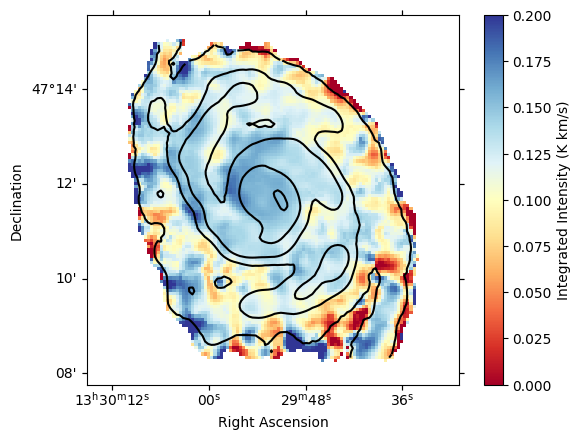

In [59]:
ax = plt.subplot(projection=masked_moment0_13co.wcs)
im = ax.imshow(masked_moment0_13co.value/masked_moment0_12co.value, origin='lower', vmax=.2, vmin=0,cmap='RdYlBu')
cbar = plt.colorbar(im)
cbar.set_label('Integrated Intensity (K km/s)')
ax.contour(masked_moment0_12co.value/1000, colors='k', levels=[1,5,10,25,50,80])

ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')

# Line Ratio Analsyis
A common analysis to perform with the line ratio is:
* Describe line ratio statistcis (mean, standard deviation, ...).
* Study trends across the source.

In this tutorial, we will illustrate ways to assess the ratio statistics and in particular look how we can describe radial trends, accounting for the galaxies inclination and position angle

### i) Uncertainty of the Line Ratio Measurement

To determine the uncertainty in the ratio, $\sigma_{\rm r}$, we can simply propagate the uncertainties of the individual lines, $\sigma_{\rm line\,1}$ and $\sigma_{\rm line\,2}$, as follows:
$$
\sigma_{\rm r} = \frac{I_{\rm line\,1}}{I_{\rm line\,2}}\cdot\sqrt{\left(\frac{\sigma_{\rm line\,1}}{I_{\rm line\,1}}\right)^2+\left(\frac{\sigma_{\rm line\,2}}{I_{\rm line\,2}}\right)^2}
$$

**Determiening the integrated line intensity uncertainty:** We have not yet explained, how we determine the uncertainty of the line intensities. As we have the channel rms, we simply find the uncertainty by calculating:
$$
\sigma_{\rm line} = {\rm rms}\cdot\Delta v\cdot\sqrt{n_{\rm chan}}
$$
where $n_{\rm chan}$ indicates the number of channels we integrate over.


In [26]:
#We get the number of channels we integrate over by summing over the mask along the spectral axis
n_chan_cube = np.nansum(signal_mask, axis=0)

#following example above, we compute the channel rms for 12CO and 13CO
mad_std_map_12co = cube_12co_conv_reproj.mad_std(axis=0)
mad_std_map_12co = cube_12co_conv_reproj.with_mask(cube_12co_conv_reproj<3*mad_std_map_12co).mad_std(axis=0)

mad_std_map_13co = cube_13co.mad_std(axis=0)
mad_std_map_13co = cube_13co.with_mask(cube_13co<3*mad_std_map).mad_std(axis=0)

#compute the uncertaitny of the intensity
unc_ii_12co = mad_std_map_12co.value*cube_12co_conv_reproj.header['CDELT3']*np.sqrt(n_chan_cube)
unc_ii_13co = mad_std_map_13co.value*cube_13co.header['CDELT3']*np.sqrt(n_chan_cube)

/opt/homebrew/lib/python3.11/site-packages/astropy/stats/funcs.py:816: RuntimeWarning: All-NaN slice encountered
  data_median = func(data, axis=axis)
/opt/homebrew/lib/python3.11/site-packages/astropy/stats/funcs.py:822: RuntimeWarning: All-NaN slice encountered
  result = func(np.abs(data - data_median), axis=axis, overwrite_input=True)
/opt/homebrew/lib/python3.11/site-packages/astropy/stats/funcs.py:816: RuntimeWarning: All-NaN slice encountered
  data_median = func(data, axis=axis)
/opt/homebrew/lib/python3.11/site-packages/astropy/stats/funcs.py:822: RuntimeWarning: All-NaN slice encountered
  result = func(np.abs(data - data_median), axis=axis, overwrite_input=True)
/opt/homebrew/lib/python3.11/site-packages/astropy/stats/funcs.py:816: RuntimeWarning: All-NaN slice encountered
  data_median = func(data, axis=axis)
/opt/homebrew/lib/python3.11/site-packages/astropy/stats/funcs.py:822: RuntimeWarning: All-NaN slice encountered
  result = func(np.abs(data - data_median), axis=axis,

**Propagate the Uncertainty to determine the error in line ratio**

In [28]:
#compute first the term in the square-rootot
term1=unc_ii_13co/masked_moment0_13co.value
term2=unc_ii_12co/masked_moment0_12co.value

sqrt_term = np.sqrt((term1)**2+(term2)**2)

#resulting uncertainty
unc_ratio = masked_moment0_13co.value/masked_moment0_12co.value*sqrt_term

### ii) Sample-wide Ratio Distribution

### iii) Radial Trends in the Line Ratio